<a href="https://colab.research.google.com/github/Hyewon-Git/2021_HUFS_NLP/blob/main/%ED%98%9C%EC%9B%90_NLP_05_01_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 15.9MB/s 


# Evn

In [ ]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [ ]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
!nvidia-smi

Fri Jan 29 01:49:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/Colab Notebooks/2021-HUFS-NLP/data'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'kowiki2']

In [ ]:
# nsmc dir
nsmc_dir = os.path.join(data_dir, 'nsmc')
if not os.path.exists(nsmc_dir):
    os.makedirs(nsmc_dir)
os.listdir(nsmc_dir)

[]

# Vocabulary & config

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [ ]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 47  # number of sequence
d_model = 256  # dimension of model 차원수!
n_out = 2  # number of output class 클래스개수 --긍정/부정으로할꺼여서

# 모델링

In [ ]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [1, 0]  # 긍정(1), 부정(0)

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [ ]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences: #띄어씌기로 단어 split 하고 , word_to_id로 글자를 숫자로 바꿔서 train_input에 넣어줌
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train label
train_labels = labels #위에서지정해준 labe [1,0] 긍정 부정으로

# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:#길이 동일하게변환
    row += [0] * (4 - len(row))

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)

train_inputs, train_labels

(array([[2, 3, 4, 5],
        [2, 3, 6, 0]]), array([1, 0]))

In [ ]:
#여기서부터제대로 시작~~
# 1. 입력 단어를 vector로 변환
embedding =tf.keras.layers.Embedding(len(word_to_id), 5) #보기어려우니 test용으로 간단히 5로
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
array([[[-0.00226969,  0.00098121, -0.02956598,  0.03029363,
          0.0141835 ],
        [ 0.04274947,  0.00848954,  0.0289362 ,  0.02202288,
         -0.01791685],
        [ 0.04709952,  0.03384167,  0.0277797 ,  0.04307822,
         -0.02606037],
        [-0.04369395, -0.00189743, -0.02968305, -0.02934433,
          0.03379652]],

       [[-0.00226969,  0.00098121, -0.02956598,  0.03029363,
          0.0141835 ],
        [ 0.04274947,  0.00848954,  0.0289362 ,  0.02202288,
         -0.01791685],
        [ 0.00654628,  0.02580747,  0.03756353,  0.00737777,
          0.0342937 ],
        [-0.01746353, -0.03612994,  0.01480493, -0.01959816,
         -0.01632367]]], dtype=float32)>

In [ ]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
# 우리가배운 RNN, CNN, Dense로 할수있지만 skip
pool =tf.keras.layers.GlobalMaxPool1D()
hidden_pool = pool(hidden)
hidden_pool #문장을 대표하는 vector임


<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.04709952, 0.03384167, 0.0289362 , 0.04307822, 0.03379652],
       [0.04274947, 0.02580747, 0.03756353, 0.03029363, 0.0342937 ]],
      dtype=float32)>

In [ ]:
# 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax) #softmax를 이용해서 // 여기서 2는 class가 2개 그림에서 c1, c2를 만든것!!
outputs= linear(hidden_pool)
outputs

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5367391 , 0.46326086],
       [0.53372407, 0.46627593]], dtype=float32)>

In [ ]:
#각 함수및 과정을 (수식) 뭘 의미하는지 다시정리할것!!

In [ ]:
# 예측을 위한 wegiths
weight ,bias = linear.get_weights()
weight , bias #weight : 5개의 입력을 2의 출력으로 
#weight의 결과값 : [왼,오]일때 행벡터f와 열벡터c1이 가깝다면 결과값이 0에 가깝다.???????????


(array([[ 0.1805532 , -0.364518  ],
        [ 0.9215275 ,  0.5707779 ],
        [-0.15351784, -0.8821234 ],
        [ 0.20463693, -0.87751895],
        [ 0.88342905, -0.35867918]], dtype=float32),
 array([0., 0.], dtype=float32))

In [ ]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    문장의 감정분류 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    ######################################################
    #입력단어 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs) #(bs, n_seq, d_model)

    # RNN, CNN, Dense

    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장vector 생성) CNN인가 RNN에서는 과정중알아서해줌
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool = pool(hidden)  # (bs, d_model)

    # 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
    linear = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)
    outputs = linear(hidden_pool)  # (bs, n_out)

    ######################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

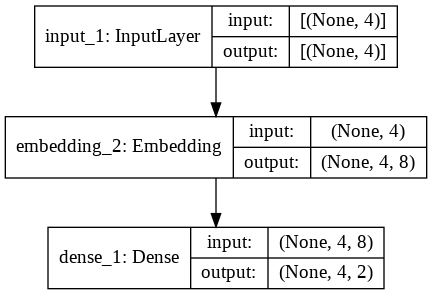

In [ ]:
# 모델 생성
model = build_model(len(word_to_id), 8, 4, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs)

array([[[0.47223195, 0.527768  ],
        [0.5186803 , 0.48131976],
        [0.50900805, 0.49099195],
        [0.5019966 , 0.49800345]],

       [[0.47223195, 0.527768  ],
        [0.5186803 , 0.48131976],
        [0.51926553, 0.48073447],
        [0.5040662 , 0.49593377]]], dtype=float32)

In [ ]:
##** test와 train을 나누는 이유
#: 같다면 실제 모델 실제에 편중된 데이터가 나올수있어서!
#(train, valid, test)로나눔!

# 다운로드
- https://github.com/e9t/nsmc

In [ ]:
# naver movie sentiment corpus v1.0

In [ ]:
!wget https://github.com/e9t/nsmc/raw/master/ratings_train.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_test.txt

--2021-01-29 02:43:09--  https://github.com/e9t/nsmc/raw/master/ratings_train.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt [following]
--2021-01-29 02:43:09--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.06s   

2021-01-29 02:43:09 (217 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2021-01-29 02:43:09--  https://github.com/e9t/nsmc/raw/master/ratin

In [ ]:
shutil.move('ratings_train.txt', os.path.join(nsmc_dir, 'ratings_train.txt'))
shutil.move('ratings_test.txt', os.path.join(nsmc_dir, 'ratings_test.txt'))
os.listdir(nsmc_dir)

['ratings_train.txt', 'ratings_test.txt']

# 데이터 분석

In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# train null 데이터 제거
df_train = df_train.dropna() #dropnall --> null data삭제
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## Char

In [ ]:
# char 길이 데이터
char_len = df_train["document"].astype("str").apply(len)
char_len.head(10)

0    19
1    33
2    17
3    29
4    61
5    45
6    21
7    86
8    22
9    45
Name: document, dtype: int64

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


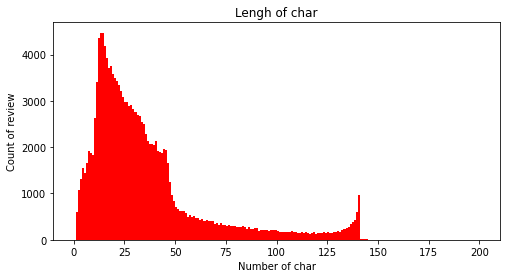

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=200, range=[0, 200], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:     146
char 길이 최소:       1
char 길이 평균:      35.20
char 길이 표준편차:   29.53
char 25/100분위:    16.00
char 50/100분위:    27.00
char 75/100분위:    42.00
char IQR:          26.00
char MAX/100분위:   81.00


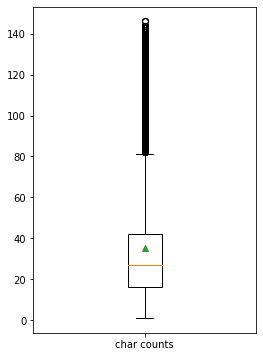

In [ ]:
plt.figure(figsize=(4, 6))
# '박스플롯'으로 그려보면
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()
#시커먼부분 : out rain으로 비정상적으로 긴 부분으로 취급

## Word

In [ ]:
# word 길이 데이터
word_len = df_train['document'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0     5
1     4
2     1
3     6
4    11
5     8
6     4
7    13
8     6
9    10
Name: document, dtype: int64

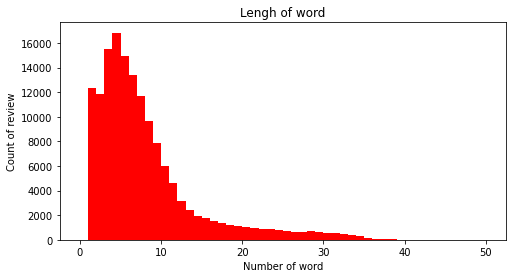

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=50, range=[0, 50], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      41
word 길이 최소:       1
word 길이 평균:       7.59
word 길이 표준편차:    6.51
word 25/100분위:     3.00
word 50/100분위:     6.00
word 75/100분위:     9.00
word IQR:           6.00
word MAX/100분위:   18.00


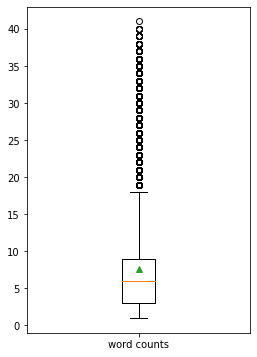

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

## SentencePiece

In [ ]:
# word 길이 데이터
spm_len = df_train['document'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x))) # vocab.encode_as_pieces(x)로 토큰화하고, 잘라서 길이를 측정한건
spm_len.head(10)

0    11
1    25
2    11
3    18
4    38
5    33
6    11
7    61
8    10
9    29
Name: document, dtype: int64

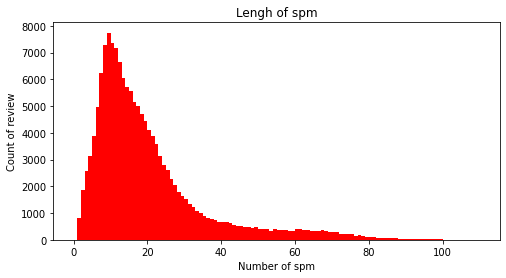

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=110, range=[0, 110], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()
#char 하고 word의 중간값에 있음!!@

In [ ]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:     141
spm 길이 최소:       1
spm 길이 평균:      19.77
spm 길이 표준편차:   15.87
spm 25/100분위:     9.00
spm 50/100분위:    15.00
spm 75/100분위:    24.00
spm IQR:          15.00
spm MAX/100분위:   46.50


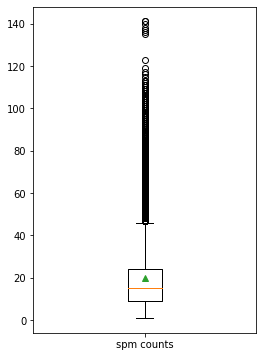

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

## Label

In [ ]:
df_train['label'].value_counts()

0    75170
1    74825
Name: label, dtype: int64

In [ ]:
# label count
print(f"부정 리뷰 개수: {df_train['label'].value_counts()[0]}")
print(f"긍정 리뷰 개수: {df_train['label'].value_counts()[1]}")

부정 리뷰 개수: 75170
긍정 리뷰 개수: 74825


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


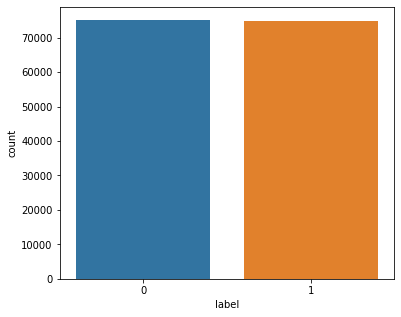

In [ ]:
# label counter plot
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 5)
# https://seaborn.pydata.org/
subplt = sns.countplot(df_train['label'])

## Word Cloud

In [ ]:
# train review documents
train_review = [review for review in df_train['document'] if type(review) is str]
train_review[:10]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?']

In [ ]:
' '.join(train_review[:10])

'아 더빙.. 진짜 짜증나네요 목소리 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 너무재밓었다그래서보는것을추천한다 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움. 원작의 긴장감을 제대로 살려내지못했다. 별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네 액션이 없는데도 재미 있는 몇안되는 영화 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?'

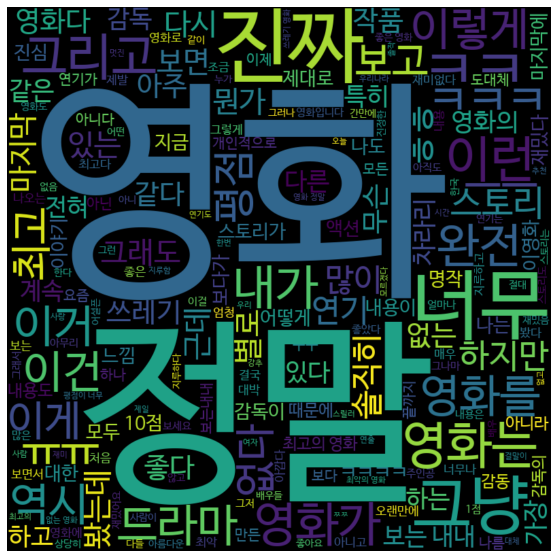

In [ ]:
# WordCloud
# window: C:/Windows/Fonts/malgun.ttf, mac: /Library/Fonts/AppleGothic.ttf, colab: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(10, 10))
# https://datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sample Data Project

## Data


In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,id,document,label
96824,8077320,어제 다시 봤는데 감동적이네요.,1
414,7538996,최고의영화,1
136957,8881843,견자단영화 찾으려고 썼더니 이상한게 나오고있어 ㄲㅈ,0
27464,8495180,그냥 보면서 피식. 뭔가따듯해서좋앗음,1
35499,10125017,몇몇 씬들은 정말 인상적이었다,1
29677,120624,유치하죠..,0
76034,8551408,아까운 내 시간....,0
6716,6624395,오글오글 개허세 허세도이런 허세가없네 보는내내 오글거리고 막장이고 똥멋든 깡패의 사...,0
142414,363915,.,0
46023,10253023,영화인 듯 영화 아닌 영화 같은 관객과 썸 타는 오늘 영화!,1


In [ ]:
# 랜덤하게 10개만 확인
df_test = df_test.sample(10)
df_test

,id,document,label
5964,6038478,역시 빠순이의 점수 대단해,0
2034,10132923,어른도 재미있는영화^^ 보고 있으니 요괴들이 귀여워져요~,1
5716,10213468,"우리나라 참 까는거 좋아해요 공인답게, 그 동생은 진실규명 똑바로 해야하는 건 맞는...",1
11621,5205062,댄의 리얼 라이프는 찌질찌질찌질찌질,0
31633,8154331,19금이 왜케 유치해?성인들을 물로보나ㅋ 마지막 장면 개민폐 어쩔 ㅋ걍 짜증만 난다...,0
11315,9560834,천옌시 귀요미 ㅋㅋ 예압,1
45316,10005582,이래서 내가 우리나라 영화를 잘 안보는건지도... 발전이 없잖아.. 발전이...,0
37152,8937433,아프간 선교 좋아하네 풉^…^,0
8015,8845171,시간이 지나도 ..지나도그때의 그 마음을 잊을수 없는 그런 ...영화,1
28244,6189666,방어율 낮춰 드릴께요.,0


In [ ]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        ######################################
        print()
        label =row['label']
        document = row['document']
        print(label,document)

        tokens = vocab.encode_as_pieces(document)
        print(len(tokens), ':', tokens)

        token_ids =vocab.encode_as_ids(document)
        print(len(token_ids),':', token_ids)

        token_ids = token_ids[:n_seq] #긴건짤라주기
        print(len(token_ids), ':',token_ids)

        token_ids += [0]* (n_seq - len(token_ids)) #ㅈ랍은건 pad 추가
        print(len(token_ids), ':', token_ids)

        #값저장
        labels[index] = label
        inputs[index] = token_ids
        index+=1
    ##실제 test에서는 print는 다지워줘야함!! 지금은 10개데이터만사용하므로 ㄱㅊ한거지만 나중에는안됨!!
        ######################################
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels

In [ ]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels

## 학습

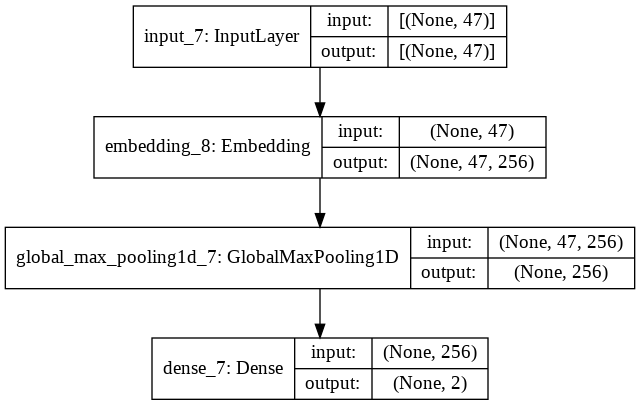

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
#( ?, 47,2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #word2Vec에서 배웟듯이 crossentropy를 씀!!

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100, #100번해라
                    batch_size=4) #한번에 

Epoch 1/100
3/3 [==============================] - 1s 176ms/step - loss: 0.6936 - accuracy: 0.4500 - val_loss: 0.6879 - val_accuracy: 0.6000
Epoch 2/100
3/3 [==============================] - 0s 117ms/step - loss: 0.6783 - accuracy: 0.6312 - val_loss: 0.6883 - val_accuracy: 0.6000
Epoch 3/100
3/3 [==============================] - 0s 90ms/step - loss: 0.6517 - accuracy: 1.0000 - val_loss: 0.6869 - val_accuracy: 0.6000
Epoch 4/100
3/3 [==============================] - 0s 90ms/step - loss: 0.6433 - accuracy: 1.0000 - val_loss: 0.6865 - val_accuracy: 0.6000
Epoch 5/100
3/3 [==============================] - 0s 88ms/step - loss: 0.6231 - accuracy: 1.0000 - val_loss: 0.6856 - val_accuracy: 0.7000
Epoch 6/100
3/3 [==============================] - 0s 89ms/step - loss: 0.6070 - accuracy: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.7000
Epoch 7/100
3/3 [==============================] - 0s 90ms/step - loss: 0.5924 - accuracy: 1.0000 - val_loss: 0.6821 - val_accuracy: 0.7000
Epoch 8/100
3/3 [=

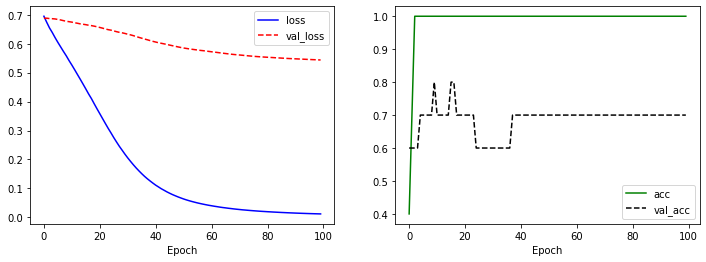

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
#overfitting : parameter을 많이 쌓으면 weight를 깊게쌓으면 --> 너무많은 데이터로인해 모든 데이터에 맞추려다보니 이상해질수있음!

## 학습 2

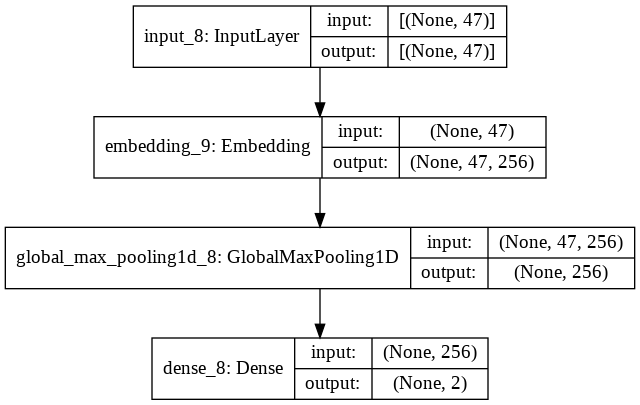

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20) #보통 5로씀/ 20번은 많음! 우리는 10data만 사용하니깐 이렇게하는것! ===> 20번정도 반복하면 멈춰라!
#학습끝나고쓸려면 weight를 저장해야함 --> checkpoint라고함!
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'), #stub : 껍데기 == 단어vector*Maxpooling만 한상태니깐!
                                                  monitor='val_accuracy', #측정방법
                                                  verbose=1,
                                                  save_best_only=True, #좋은것만 저장을 해라
                                                  mode="max",
                                                  save_freq="epoch", #얼마나자주
                                                  save_weights_only=True) #model까지저장하면 tf가 문제가 생김 --> weight만 저장함!
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger]) #모델학습하면서 callback저장까지함

Epoch 1/100
1/1 [==============================] - 1s 551ms/step - loss: 0.6900 - accuracy: 0.5000 - val_loss: 0.6876 - val_accuracy: 0.6000

Epoch 00001: val_accuracy improved from -inf to 0.60000, saving model to /content/drive/MyDrive/Colab Notebooks/2021-HUFS-NLP/data/nsmc/stub.hdf5
Epoch 2/100
1/1 [==============================] - 0s 108ms/step - loss: 0.6786 - accuracy: 0.6000 - val_loss: 0.6878 - val_accuracy: 0.6000

Epoch 00002: val_accuracy did not improve from 0.60000
Epoch 3/100
1/1 [==============================] - 0s 113ms/step - loss: 0.6676 - accuracy: 0.8000 - val_loss: 0.6879 - val_accuracy: 0.6000

Epoch 00003: val_accuracy did not improve from 0.60000
Epoch 4/100
1/1 [==============================] - 0s 110ms/step - loss: 0.6568 - accuracy: 1.0000 - val_loss: 0.6879 - val_accuracy: 0.6000

Epoch 00004: val_accuracy did not improve from 0.60000
Epoch 5/100
1/1 [==============================] - 0s 102ms/step - loss: 0.6463 - accuracy: 1.0000 - val_loss: 0.6877 - v

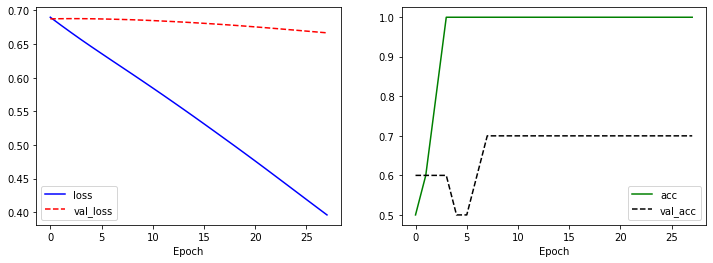

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화  ->> 학습된모델로 복원이됨
model.load_weights(os.path.join(nsmc_dir, 'stub.hdf5'))

In [ ]:
# 예측
logits = model.predict(test_inputs)
logits

array([[0.5125189 , 0.4874811 ],
       [0.5086183 , 0.49138173],
       [0.5090931 , 0.49090686],
       [0.5046653 , 0.4953347 ],
       [0.51001287, 0.48998713],
       [0.50788593, 0.49211407],
       [0.50917304, 0.49082696],
       [0.5094536 , 0.4905464 ],
       [0.5118683 , 0.48813173],
       [0.508535  , 0.49146494]], dtype=float32)

In [ ]:
# 확률 최대 값을 예측으로 사용
test_preds = np.argmax(logits, axis = -1) #argmax는
test_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# confusion matrix
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix


array([[6, 0],
       [4, 0]])

In [ ]:
# accuracy, precision, recall, f1
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.6
precision: 0.0
recall: 0.0
f1: 0.0


In [ ]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
     # token 생성: <string tokens>, [PAD] tokens
    token = vocab.encode_as_ids(string)[:n_seq]
    token += [0] * (n_seq - len(token))
    token = token[:n_seq]

    y_pred = model.predict(np.array([token]))
    y_pred_class = K.argmax(y_pred, axis=-1)

    return "긍정" if y_pred_class[0] == 1 else "부정"

In [ ]:
string = '영화 너무 심심해'
do_predict(model, n_seq, string)

'부정'

In [ ]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")

input > 나는 이영화가 좋다
output > 부정
input > 영화가좋아
output > 긍정
input > 


# All Data Project

## Data


In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

In [ ]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

In [ ]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

In [ ]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

In [ ]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        label = row['label']
        document = row['document']
        # print(label, document)
        tokens = vocab.encode_as_pieces(document)
        # print(len(tokens), ':', tokens)
        token_ids = vocab.encode_as_ids(document)
        # print(len(token_ids), ':', token_ids)
        token_ids = token_ids[:n_seq]
        # print(len(token_ids), ':', token_ids)
        token_ids += [0] * (n_seq - len(token_ids))
        # print(len(token_ids), ':', token_ids)

        labels[index] = label
        inputs[index] = token_ids
        index += 1
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels

In [ ]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'stub.hdf5'))

In [ ]:
# 예측
logits = model.predict(test_inputs)
logits

In [ ]:
# 확률 최대 값을 예측으로 사용
test_preds = np.argmax(logits, axis=-1)
test_preds

In [ ]:
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

In [ ]:
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

In [ ]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
    # token 생성: <string tokens>, [PAD] tokens
    token = vocab.encode_as_ids(string)[:n_seq]
    token += [0] * (n_seq - len(token))
    token = token[:n_seq]

    y_pred = model.predict(np.array([token]))
    y_pred_class = K.argmax(y_pred, axis=-1)

    return "긍정" if y_pred_class[0] == 1 else "부정"

In [ ]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")